C:\Users\vikto\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


(['#86acc4', '#e7b95e', '#bd841c', '#2e1c09', '#928171', '#bdcacf', '#77500f'],
 array([[146.42028954, 129.74598655, 113.20365098],
        [ 46.47056087,  28.30478831,   9.52731226],
        [119.78064718,  80.65131673,  15.40567707],
        [189.90898258, 132.41184994,  28.96572713],
        [231.39210528, 185.43677032,  94.85591601],
        [189.76583666, 202.06941592, 207.06447742],
        [134.25925499, 172.92719456, 196.22467997]]),
 array([[ 46.47056087,  28.30478831,   9.52731226],
        [119.78064718,  80.65131673,  15.40567707],
        [146.42028954, 129.74598655, 113.20365098],
        [189.90898258, 132.41184994,  28.96572713],
        [134.25925499, 172.92719456, 196.22467997],
        [231.39210528, 185.43677032,  94.85591601],
        [189.76583666, 202.06941592, 207.06447742]]),
 array([[ 46.47056087,  28.30478831,   9.52731226],
        [119.78064718,  80.65131673,  15.40567707],
        [146.42028954, 129.74598655, 113.20365098],
        [189.90898258, 132.41184

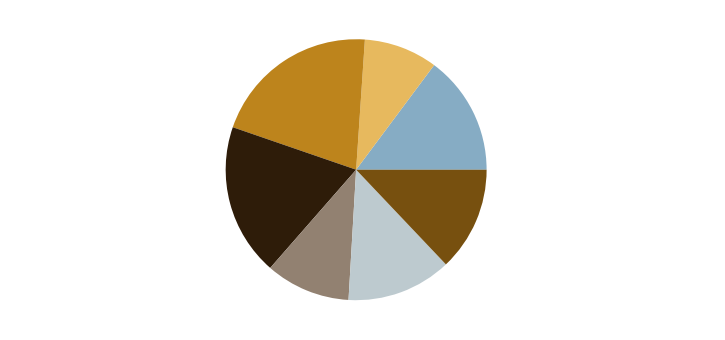

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
from json import JSONEncoder
import cv2, json, math, codecs, numpy as np, colorsys

%matplotlib inline


def rgbToHex(color):
    """
   Converts RGB to HEX

   :param numpy.ndarray color: color that needs to be converted
   :return: HEX color code as string
   """
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))


def get_image(image_path):
    """
   Converts Image to RGB

   :param string image_path: path of the image
   :return: the image
   """
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def get_colors(image, number_of_colors, show_chart):
    """
   Finds and shows colors from an image in HEX and RGB

   :param numpy.ndarray image: image itself
   :param int number_of_colors: number of colors
   :param boolean show_chart: show chart
   :return: the HEX and RGB color codes
   """
    # resizing image to reduce run time
    modified_image = cv2.resize(
        image, (1000, 1000), interpolation=cv2.INTER_AREA)
    modified_image = modified_image.reshape(
        modified_image.shape[0]*modified_image.shape[1], 3)

    # KMeans algorithm creates clusters of colors
    colorCluster = KMeans(n_clusters=number_of_colors)
    labels = colorCluster.fit_predict(modified_image)

    # counting number of labels
    counts = Counter(labels)
    center_colors = colorCluster.cluster_centers_

    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [rgbToHex(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    # showing pie chart
    if (show_chart):
        plt.figure(figsize=(8, 6))
        plt.pie(counts.values(), labels=rgb_colors,
                colors=hex_colors, textprops={'color': "w"})
                
    # Function for luminosity sorting
    def lum (r,g,b):
        return math.sqrt( .241 * r + .691 * g + .068 * b )
    rgb_colors_luminositySorted = np.array(sorted(rgb_colors, key=lambda rgb: lum(*rgb)))

    # HSV sorting
    rgb_colors_hsvSorted = np.array(sorted(rgb_colors, key=lambda rgb: colorsys.rgb_to_hsv(*rgb)))

    # Step sorting
    def step (r,g,b, repetitions=1):
        lum = math.sqrt( .241 * r + .691 * g + .068 * b )
        h, s, v = colorsys.rgb_to_hsv(r,g,b)
        h2 = int(h * repetitions)
        lum2 = int(lum * repetitions)
        v2 = int(v * repetitions)
        if h2 % 2 == 1:
            v2 = repetitions - v2
            lum = repetitions - lum
        return (h2, lum, v2)
    rgb_colors_stepSorted = np.array(sorted(rgb_colors, key=lambda rgb: step(rgb[0],rgb[1], rgb[2],8)))

    # encode numpy array into json
    class NumpyArrayEncoder(JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return JSONEncoder.default(self, obj)

    # saving the colors in a json file
    with open('colors.json', 'w') as f:
        json.dump(rgb_colors_hsvSorted, f,  cls=NumpyArrayEncoder)

    return hex_colors, rgb_colors_hsvSorted, rgb_colors_luminositySorted, rgb_colors_stepSorted

get_colors(get_image('../img/backgroundPicture.jpg'), 7, True)